##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This notebook has been authored by [Ata Colak](https://github.com/atacolak) and [Irem Oztimur](https://github.com/IremOztimur).

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/PaliGemma/[PaliGemma_1]Finetune_with_object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Fine-tune PaliGemma on Custom Object Detection Dataset

PaliGemma [(Github)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md) is a family of vision-language models with an architecture consisting of [SigLIP-So400m](https://huggingface.co/google/siglip-so400m-patch14-384) as the image encoder and [Gemma-2B](https://huggingface.co/google/gemma-2b) as text decoder. SigLIP is a state-of-the-art model that can understand both images and text. It is designed as a flexible framework capable of adapting to a variety of vision-language tasks, including image and video captioning, visual question answering, text recognition, object detection, and segmentation.

In addition to pretrained and transfer checkpoints across different resolutions, PaliGemma provides a specialized checkpoint fine-tuned on a blend of tasks, enabling straightforward experimentation and task exploration.

![a](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/paligemma/paligemma_arch.png)

This notebook demonstrates the process of fine-tuning [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) for a vision-language task using [JAX](https://jax.readthedocs.io/en/latest/quickstart.html). Fine-tuning allows you to enhance a model's performance for specific applications or ensure it generates desired outputs when standard instructions are insufficient. By providing example outputs, you can guide the model to better meet task-specific requirements. Gemma-based models, including PaliGemma, often benefit from fine-tuning to achieve optimal results.

As the matter of fact, the base model performed poorly in detecting clothes, as evidenced by the results below. Additionally, during the training phase, a significantly high initial loss of 4.7220 was observed, indicating the need for substantial optimization.

![a](https://i.imgur.com/pg1cWau.png)

The dataset includes 4.5k samples of pieces of clothing, with images rescaled to 224x224. [It can be accessed here.](https://universe.roboflow.com/fashionistai/fashionistaiv4)

To run this on a T4 Colab environment with 16GB of high-bandwidth memory and 12GB of RAM, only the attention layers of the language model were fine-tuned, while keeping the remaining parameters frozen.

## Setup

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [`Kaggle`](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [`PaliGemma Model Card`](https://www.kaggle.com/models/google/paligemma/) and click `Request Access`.
1. Complete the consent form and accept the terms and conditions.

### Configure your API keys

To use PaliGemma, you need to provide your Kaggle username, Kaggle API key, and Roboflow API key. Follow these steps:

- Open your [`Kaggle Settings`](https://www.kaggle.com/settings) page. Click `Create New Token`. This will download a `kaggle.json` file containing your API credentials.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store Kaggle Username under the name `KAGGLE_USERNAME`.
    - Store Kaggle API Key under the name `KAGGLE_KEY`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that you have access to GPU. you can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

### Download dataset from Roboflow Universe

In [ ]:
!pip install -q roboflow
!pip install -q git+https://github.com/roboflow/supervision.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from roboflow import Roboflow
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("fashionistai").project("fashionistaiv4")
version = project.version(4)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fashionistAIv4-4 in paligemma:: 100%|██████████| 4570/4570 [00:01<00:00, 2337.84it/s]


In [ ]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"1607488651407_d2wyq3yi4z5_jpg.rf.ad9a3cf57ae23e276b00632986883a50.jpg","prefix":"detect dress ; flannel ; glasses ; jacket ; pants ; scarf ; shirt ; shoes ; short ; skirt ; sweater ; watch","suffix":"<loc0092><loc0145><loc0963><loc0947> shirt"}
{"image":"Dimage3105_jpg.rf.ad9a63a7fb3ee78708ac40f768296ce3.jpg","prefix":"detect dress ; flannel ; glasses ; jacket ; pants ; scarf ; shirt ; shoes ; short ; skirt ; sweater ; watch","suffix":"<loc0073><loc0142><loc0964><loc0812> dress"}
{"image":"14_jpg.rf.adbd7e85e12281d099985151c5c79927.jpg","prefix":"detect dress ; flannel ; glasses ; jacket ; pants ; scarf ; shirt ; shoes ; short ; skirt ; sweater ; watch","suffix":"<loc0170><loc0257><loc0529><loc0730> sweater ; <loc0505><loc0347><loc0930><loc0662> pants"}
{"image":"Himage9905_jpg.rf.add163b43c0dc563ee8e2584a6cd24ae.jpg","prefix":"detect dress ; flannel ; glasses ; jacket ; pants ; scarf ; shirt ; shoes ; short ; skirt ; sweater ; watch","suffix":"<loc0137><loc0265><loc1023><loc

In [ ]:
!head -n 5 {dataset.location}/dataset/_annotations.valid.jsonl

{"image":"img_0716_jpeg_jpg.rf.00f407be326a59dbc2f4e971dd200bd9.jpg","prefix":"detect dress ; flannel ; glasses ; jacket ; pants ; scarf ; shirt ; shoes ; short ; skirt ; sweater ; watch","suffix":"<loc0176><loc0252><loc0985><loc0698> dress"}
{"image":"Himage9194_jpg.rf.02da8544b388bd97498a8a6308bed31c.jpg","prefix":"detect dress ; flannel ; glasses ; jacket ; pants ; scarf ; shirt ; shoes ; short ; skirt ; sweater ; watch","suffix":"<loc0005><loc0093><loc0501><loc0404> sweater ; <loc0003><loc0365><loc0504><loc0621> sweater ; <loc0009><loc0685><loc0324><loc0905> sweater ; <loc0002><loc0860><loc0317><loc1022> sweater ; <loc0326><loc0672><loc0674><loc0900> sweater ; <loc0306><loc0850><loc0589><loc1023> sweater ; <loc0516><loc0070><loc1023><loc0409> sweater ; <loc0494><loc0362><loc0986><loc0625> sweater ; <loc0694><loc0660><loc1005><loc0884> sweater ; <loc0672><loc0854><loc0969><loc1023> sweater"}
{"image":"1592230461320_pdfd3vp6oep_jpg.rf.00e88af2bcfb02aedbf916f39ca9775e.jpg","prefix":"d

### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings:

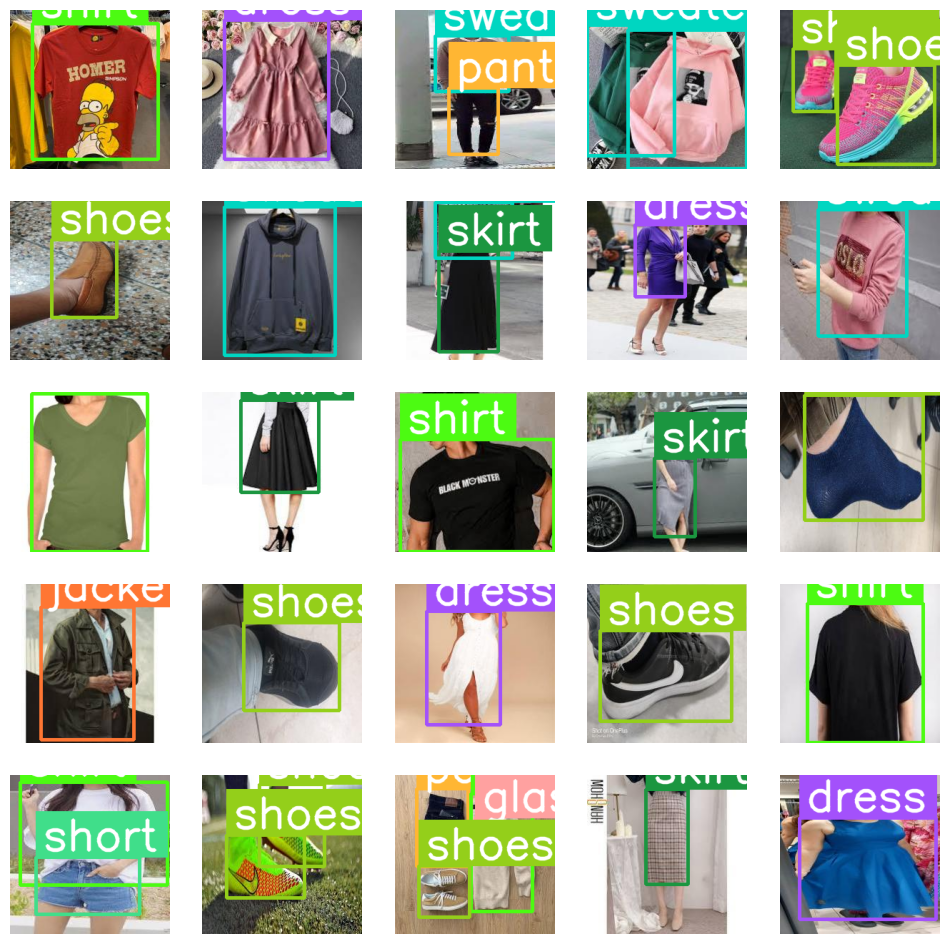

In [ ]:
import cv2
import json
import supervision as sv
from typing import List

def read_n_lines(file_path: str, n: int) -> List[str]:
    with open(file_path, 'r') as file:
        lines = [next(file).strip() for _ in range(n)]
    return lines

images = []
lines = read_n_lines(f"{dataset.location}/dataset/_annotations.train.jsonl", 25)
first = json.loads(lines[0])

CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")

for line in lines:
    data = json.loads(line)
    image = cv2.imread(f"{dataset.location}/dataset/{data.get('image')}")
    (h, w, _) = image.shape
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=data.get('suffix'),
        resolution_wh=(w, h),
        classes=CLASSES)

    image = sv.BoundingBoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

In [ ]:
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


### Set environment variables

Set the environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [ ]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [ ]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image
from tqdm.notebook import tqdm

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.33
JAX platform: gpu
JAX devices:  1


## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

### Download the model checkpoint

PaliGemma includes several model variations. For this tutorial, you'll use the base [JAX/FLAX PaliGemma 3B weight model](https://www.kaggle.com/models/google/paligemma/jax/paligemma-3b-pt-224).

Download the `float16` version of the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [ ]:
import os
import kagglehub

MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    # Note: kaggle archive contains the same checkpoint in multiple formats.
    # Download only the float16 model.
    MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [06:02<00:00, 16.1MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
\ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


### Configure the model

It's time to actually start configuring the model.

For this notebook, you need to be able to fit your model onto a T4 GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be *frozen* when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the `model_config` as a [`FrozenConfigDict`](https://github.com/google/ml_collections/tree/master#frozenconfigdict) so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma `Model` class using the `model_config` as its configurations
* Load the model parameters into RAM
* Define a `decode` function to sample outputs from the model

This code in this cell takes about a minute to run to completion.

In [ ]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as `float16`, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [ ]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead you do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.


In [ ]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)

### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once. This allows you to do some data pre-processing before use.
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results.

In [ ]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.train.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.valid.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


### View training examples

In this notebook, the training data contains 90 images that are paired with long descriptions of what's depicted in the image.

**Note:** Normal training data sets that are meant to be used for practical use cases should contain more images, but this notebook limits the number of data points so that you can train the model in a reasonable amount of time for an example.

The code below prints a random selection of images with their descriptions from the training data set so that you can see what the images and descriptions your model is trained on looks like. Each image is displayed in as a 128x128 pixel JPEG, with the description printed next to the image to the right.

Training examples


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



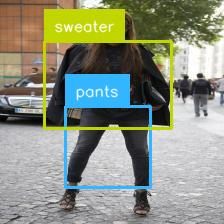
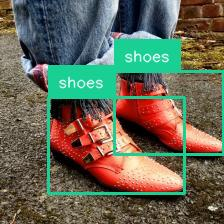
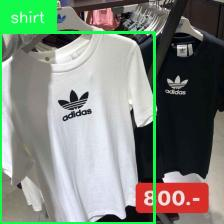
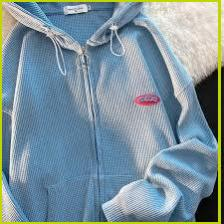

In [ ]:
def split_and_keep_second_part(s):
    parts = s.split('\n', 1)
    if len(parts) > 1:
        return parts[1]
    return s

def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
    image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    h, w, _ = image.shape
    try:
        detections = sv.Detections.from_lmm(
            lmm='paligemma',
            result=caption,
            resolution_wh=(w, h),
            classes=CLASSES)
        image = sv.BoundingBoxAnnotator().annotate(image, detections)
        image = sv.LabelAnnotator().annotate(image, detections)
    except:
        print(caption)
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
    <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
</div>
"""

html_out = ""
for idx, example in zip(range(4), train_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input.
    caption = split_and_keep_second_part(caption)
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

#### Defining the training loop

The `update_fn` function defines the core of the training loop. During the training step, the loss per example is calculated and stochastic gradient descent (SGD) is applied to the trainable parameters.

Recall that earlier in the notebook, you included flags in the `preprocess_tokens` function that included `mask_loss`. You'll use the `mask_loss` flag here to exclude prefix and padded tokens from the loss. Without it, the loss calculation will be skewed. You also need to normalize each example, since each of them has a different number of tokens. After the prefix and padded tokens have been excluded and the examples have been normalized, you can calculate the loss per example.

The training step also includes a function to apply an SGD to optimize the training.

#### Defining the evaluation loop

The `make_predictions` function is your evaluation loop. The evaluation loop is fairly straight forward with one notable change. If you recall from the beginning of the notebook, you only have 90 examples in your training data set. This is a very small amount of training examples, and your model ends up not having enough examples for the batch size when you run the training. This means that in the evaluation loop, you need to pad the batch by repeating examples.

To make sure that your evaluation loop only counts actual examples and not the padded examples, you have to apply a mask to the padded examples that excludes them from the output.

In [ ]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens you normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    labels = [postprocess_tokens(e["label"]) for e in examples]
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, label, response in zip(examples, labels, responses):
      outputs.append((example["image"], label, response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



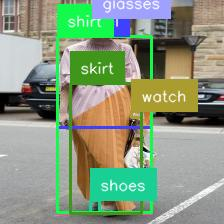
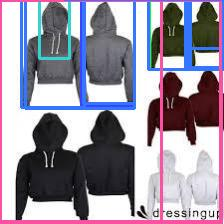
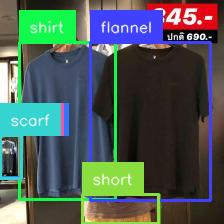
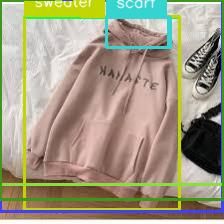

In [ ]:
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=4, batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))

## Tune the model


The code chunk below runs the training loop for the model for **80** steps and prints the **learning rate** (lr) and **loss** at each step.

Every **10** steps, the model prints its predictions at that step in the training. Printing out the predictions on the same set of images allows observation of how the model improves its predictions over time.

The model's predictions become steadily more accurate as training progresses, and by step 80, the model's predictions should closely resemble the descriptions provided by the training data.

This process took 16 minutes to finalize on T4 GPUs on Colab.

step:  1/80   lr: 0.00052   loss: 4.7220
step:  2/80   lr: 0.00105   loss: 5.3087
step:  3/80   lr: 0.00157   loss: 3.1928
step:  4/80   lr: 0.00210   loss: 3.9003
step:  5/80   lr: 0.00262   loss: 2.8582
step:  6/80   lr: 0.00315   loss: 3.0757
step:  7/80   lr: 0.00367   loss: 2.8270
step:  8/80   lr: 0.00420   loss: 3.4921
step:  9/80   lr: 0.00420   loss: 3.8576
step: 10/80   lr: 0.00419   loss: 3.3750
Model predictions at step 10


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



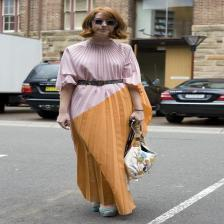
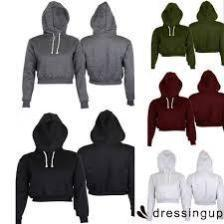
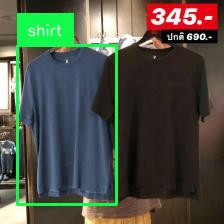
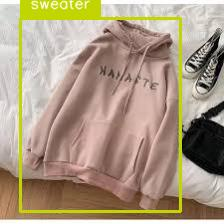

step: 11/80   lr: 0.00418   loss: 3.0455
step: 12/80   lr: 0.00417   loss: 2.9102
step: 13/80   lr: 0.00415   loss: 2.9402
step: 14/80   lr: 0.00413   loss: 3.1074
step: 15/80   lr: 0.00411   loss: 3.1839
step: 16/80   lr: 0.00408   loss: 2.7444
step: 17/80   lr: 0.00404   loss: 2.6227
step: 18/80   lr: 0.00401   loss: 2.7444
step: 19/80   lr: 0.00397   loss: 2.7186
step: 20/80   lr: 0.00393   loss: 2.9827
Model predictions at step 20


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



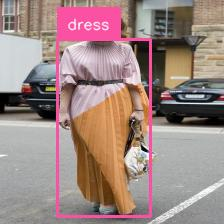
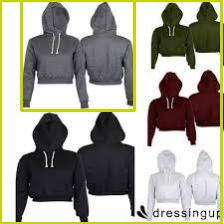
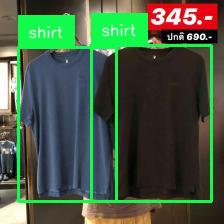
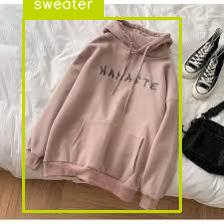

step: 21/80   lr: 0.00388   loss: 2.6496
step: 22/80   lr: 0.00383   loss: 2.8905
step: 23/80   lr: 0.00378   loss: 2.7384
step: 24/80   lr: 0.00372   loss: 2.5366
step: 25/80   lr: 0.00366   loss: 2.4787
step: 26/80   lr: 0.00360   loss: 2.7494
step: 27/80   lr: 0.00354   loss: 2.7682
step: 28/80   lr: 0.00347   loss: 2.7577
step: 29/80   lr: 0.00340   loss: 2.6637
step: 30/80   lr: 0.00333   loss: 3.0500
Model predictions at step 30


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



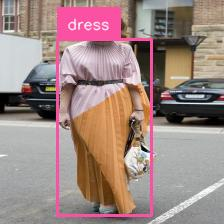
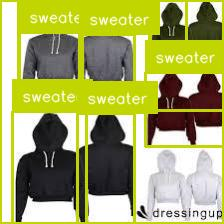
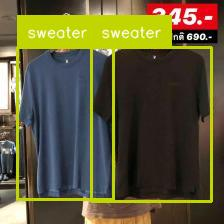
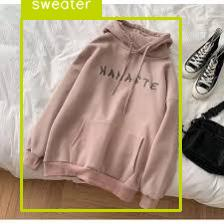

step: 31/80   lr: 0.00325   loss: 2.7908
step: 32/80   lr: 0.00318   loss: 2.5192
step: 33/80   lr: 0.00310   loss: 2.5942
step: 34/80   lr: 0.00302   loss: 2.6365
step: 35/80   lr: 0.00293   loss: 2.5486
step: 36/80   lr: 0.00285   loss: 2.4752
step: 37/80   lr: 0.00277   loss: 2.7989
step: 38/80   lr: 0.00268   loss: 2.6795
step: 39/80   lr: 0.00259   loss: 2.6406
step: 40/80   lr: 0.00250   loss: 2.4581
Model predictions at step 40


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



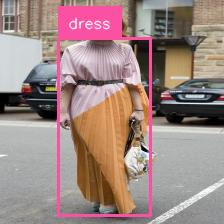
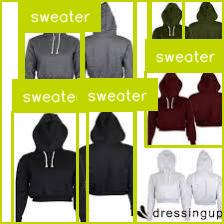
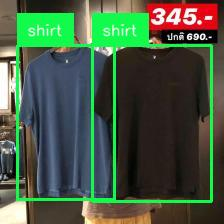
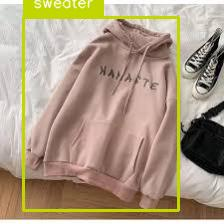

step: 41/80   lr: 0.00242   loss: 2.6402
step: 42/80   lr: 0.00233   loss: 2.8618
step: 43/80   lr: 0.00224   loss: 2.4801
step: 44/80   lr: 0.00215   loss: 2.7402
step: 45/80   lr: 0.00205   loss: 2.8069
step: 46/80   lr: 0.00196   loss: 3.0097
step: 47/80   lr: 0.00187   loss: 2.6519
step: 48/80   lr: 0.00178   loss: 2.7527
step: 49/80   lr: 0.00170   loss: 2.6589
step: 50/80   lr: 0.00161   loss: 2.4141
Model predictions at step 50


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



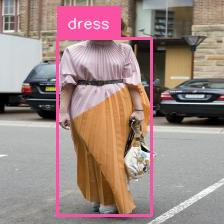
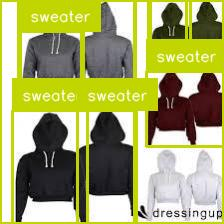
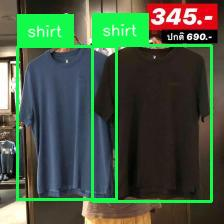
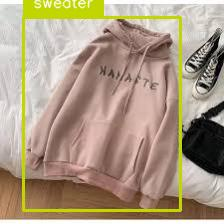

step: 51/80   lr: 0.00152   loss: 2.6813
step: 52/80   lr: 0.00143   loss: 2.6163
step: 53/80   lr: 0.00135   loss: 2.5412
step: 54/80   lr: 0.00127   loss: 2.5280
step: 55/80   lr: 0.00118   loss: 2.8320
step: 56/80   lr: 0.00110   loss: 2.5745
step: 57/80   lr: 0.00102   loss: 2.7122
step: 58/80   lr: 0.00095   loss: 2.5879
step: 59/80   lr: 0.00087   loss: 2.7223
step: 60/80   lr: 0.00080   loss: 2.9335
Model predictions at step 60


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



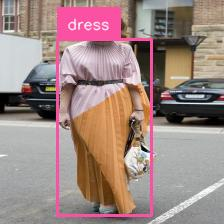
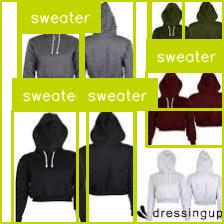
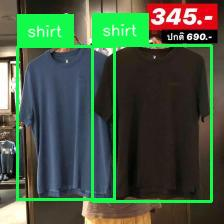
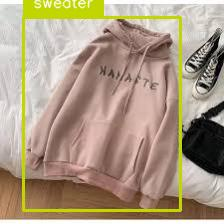

step: 61/80   lr: 0.00073   loss: 2.3929
step: 62/80   lr: 0.00066   loss: 2.5774
step: 63/80   lr: 0.00060   loss: 2.7138
step: 64/80   lr: 0.00054   loss: 2.5653
step: 65/80   lr: 0.00048   loss: 2.6573
step: 66/80   lr: 0.00042   loss: 2.3519
step: 67/80   lr: 0.00037   loss: 2.7140
step: 68/80   lr: 0.00032   loss: 2.5717
step: 69/80   lr: 0.00027   loss: 2.7111
step: 70/80   lr: 0.00023   loss: 2.6297
Model predictions at step 70


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



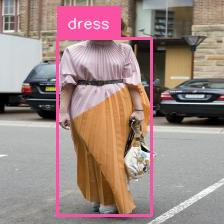
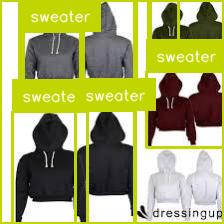
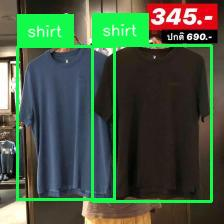
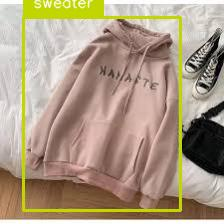

step: 71/80   lr: 0.00019   loss: 2.7307
step: 72/80   lr: 0.00016   loss: 2.6769
step: 73/80   lr: 0.00012   loss: 2.4912
step: 74/80   lr: 0.00009   loss: 2.3675
step: 75/80   lr: 0.00007   loss: 2.5622
step: 76/80   lr: 0.00005   loss: 2.4168
step: 77/80   lr: 0.00003   loss: 2.3900
step: 78/80   lr: 0.00002   loss: 2.9720
step: 79/80   lr: 0.00001   loss: 2.4456
step: 80/80   lr: 0.00000   loss: 2.5054
Model predictions at step 80


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



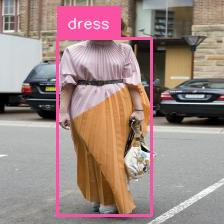
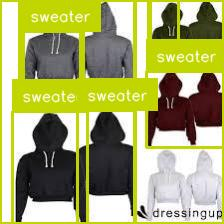
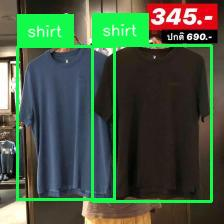
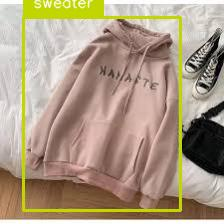

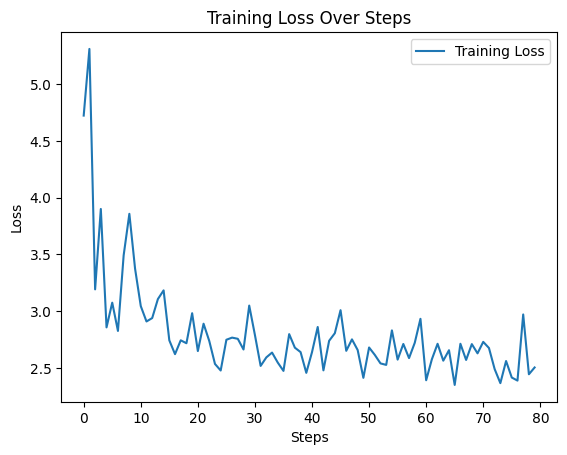

CPU times: user 6min 19s, sys: 56.1 s, total: 7min 15s
Wall time: 16min


In [ ]:
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
%%time

import matplotlib.pyplot as plt

BATCH_SIZE = 8
TRAIN_EXAMPLES = 640
LEARNING_RATE = 0.0042

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8
losses = []

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  losses.append(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, _, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))



plt.plot(losses, label='Training Loss')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Evaluate fine-tuned model

### Visualize results

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings:


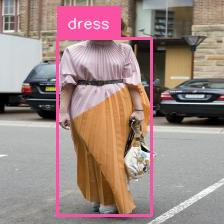
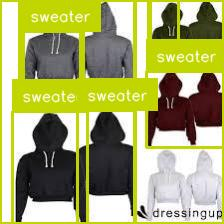
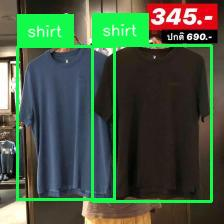
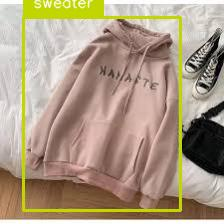
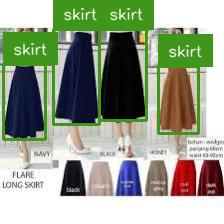
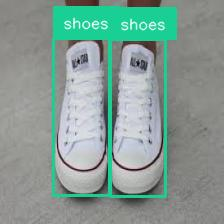
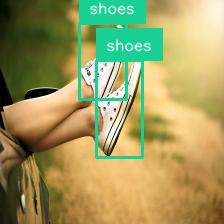
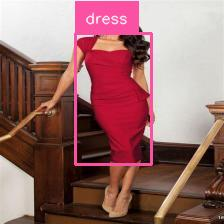
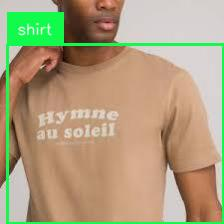
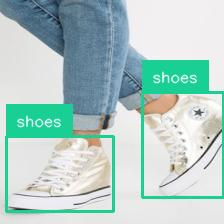
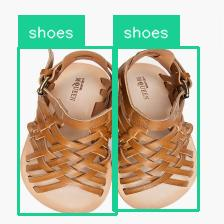
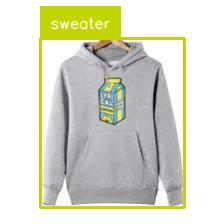
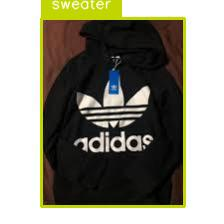
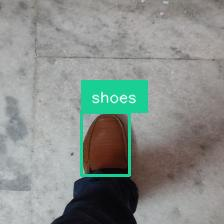
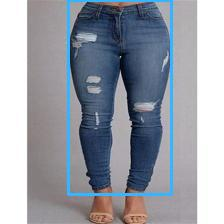
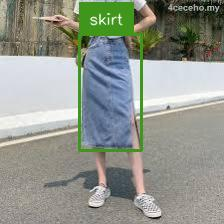

In [ ]:
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=16, batch_size=8):
  html_out += render_example(image, caption)
display(HTML(html_out))

### Collect predictions

In [ ]:
targets = []
predictions = []

for image, label, prediction in make_predictions(validation_data_iterator(), num_examples=512, batch_size=8):
    h, w, _ = image.shape
    target = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label,
        resolution_wh=(w, h),
        classes=CLASSES)
    targets.append(target)
    prediction = sv.Detections.from_lmm(
        lmm='paligemma',
        result=prediction,
        resolution_wh=(w, h),
        classes=CLASSES)
    prediction.confidence = np.ones(len(prediction))
    predictions.append(prediction)

### Calculate mAP [(Mean Average Precision)](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision)

In [ ]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.65
map50: 0.78
map75: 0.74


### Calculate Confusion Matrix

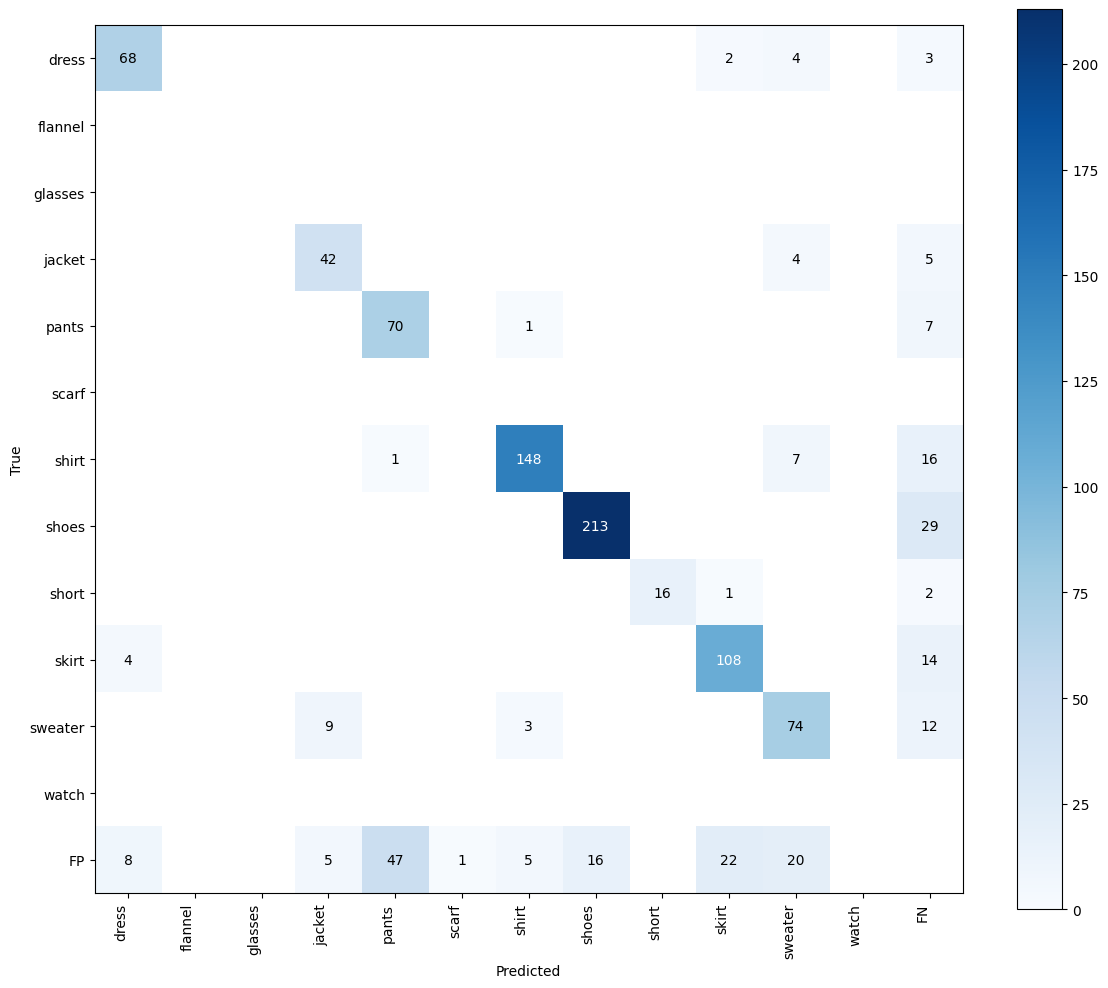

In [ ]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

## Save fine-tuned model locally

In [ ]:
import os

TARGET_MODEL_DIR = f"{dataset.location}/model"
TARGET_MODEL_PATH = f"{TARGET_MODEL_DIR}/my-custom-paligemma-3b-pt-224.f16.npz"

os.makedirs(TARGET_MODEL_DIR, exist_ok=True)

In [ ]:
flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open(TARGET_MODEL_PATH, "wb") as f:
  np.savez(f, **{k: v for k, v in flat})

## Conclusion

This notebook demonstrated the fine-tuning of Paligemma on a fashion dataset for object detection. While the complete dataset of 4.5k images could not be utilized due to resource constraints, a subset of 640 images was used, which resulted in measurable improvements in detecting clothing items.

Model was fine-tuned for 80 steps on T4 GPUs;
Loss was reduced from 4.7220 to 2.5054.

Due to resource limitations, all layers except for the **attention layers** were frozen.
Although only the **attention layers** were fine-tuned, the model had a significant increase in **mean average precision** scores, having a mAP50 of 78% and mAP75 of 74%, which indicates that the attention layers contribute to object detection tasks **significantly** in domain specific fine-tuning. This work shows the adaptability of the **Paligemma** model in resource-constrained scenarios, and the potential it has on domain specific applications.

### Resources

* [Fine-tune PaliGemma on Object Detection Dataset](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-paligemma-on-detection-dataset.ipynb)

* [Mean Average Precision](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision)

* [Paligemma Blog on Hugging Face](https://huggingface.co/blog/paligemma)